In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


2025-04-28 13:41:21.932620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745847682.187946      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745847682.262334      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean


df = pd.read_csv('data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)

df['AWS2'] = df['AWS']

features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour'] = df['datetime'].dt.hour
df['doy']  = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2 * np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2 * np.pi * df['doy']  / 365)


In [3]:
split_time = pd.Timestamp('2020-10-15 23:00:00')
df_train = df[df['datetime'] <= split_time].reset_index(drop=True)
df_test  = df[df['datetime'] >  split_time].reset_index(drop=True)

df_test_orig = df_test.copy()

scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features]  = scaler.transform(df_test[features])


In [4]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    times = data['datetime'].tolist()
    for i in range(window_size, len(data) - horizon + 1):
        if any((times[j] - times[j-1]).total_seconds() != 3600 
               for j in range(i-window_size+1, i+horizon)):
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)

window_size = 1
horizon     = 6

X_train, y_train = make_sequences(df_train, features, target, window_size, horizon)
X_test,  y_test  = make_sequences(df_test,  features, target, window_size, horizon)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test  shapes:", X_test.shape,  y_test.shape)

Train shapes: (351315, 1, 14) (351315, 6)
Test  shapes: (74038, 1, 14) (74038, 6)


Trial 5 Complete [00h 04m 12s]
val_loss: 0.2821008563041687

Best val_loss So Far: 0.24221454560756683
Total elapsed time: 00h 42m 34s
Best hyperparameters found:
  units1   = 128
  units2   = 128
  dropout1 = 0.50
  dropout2 = 0.40
  lr       = 0.0001
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8783/8783 ━━━━━━━━━━━━━━━━━━━━ 65s 7ms/step - loss: 0.1435 - mae: 0.1129 - val_loss: 0.2413 - val_mae: 0.1652
Epoch 2/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 0.1384 - mae: 0.1105 - val_loss: 0.2516 - val_mae: 0.1694
Epoch 3/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - loss: 0.1388 - mae: 0.1094 - val_loss: 0.2515 - val_mae: 0.1670
Epoch 4/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - loss: 0.1373 - mae: 0.1090 - val_loss: 0.2596 - val_mae: 0.1694
Epoch 5/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - loss: 0.1350 - mae: 0.1081 - val_loss: 0.2697 - val_mae: 0.1719
Epoch 6/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - loss: 0.1345 - mae: 0.1071 - val_loss: 0.2718 - val_mae: 0.1703
Epoch 7/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.1360 - mae: 0.1082 - val_loss: 0.2728 - val_mae: 0.1671
Epoch 8/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 59s 7ms/step - loss: 0.1312 - mae: 0.1056 - val_loss: 0.2821 - val_mae: 0.1720
Epoch 9/100
8783/8783 ━━━━━━━━━━━━━━

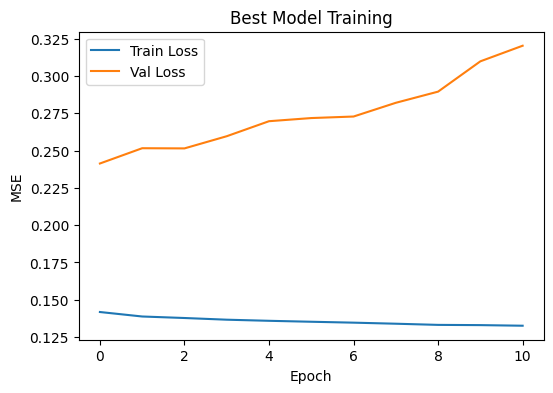

In [5]:
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


def build_stacked_lstm(window_size, n_features, horizon,
                       units1, units2, dropout1, dropout2, lr):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    # Dense output
    model.add(Dense(horizon, activation='linear'))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


def build_model_hp(hp):
    return build_stacked_lstm(
        window_size=window_size,
        n_features=len(features),
        horizon=horizon,
        units1=hp.Choice('units1', [64, 128, 256]),
        units2=hp.Choice('units2', [32, 64, 128]),
        dropout1=hp.Float('dropout1', 0.1, 0.5, step=0.1),
        dropout2=hp.Float('dropout2', 0.1, 0.5, step=0.1),
        lr=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    )

tuner = RandomSearch(
    build_model_hp,
    objective='val_loss',       
    max_trials=5,             
    executions_per_trial=1,
    directory='rs_lstm',
    project_name='lstm_rs'
)


tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)


best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(f"  units1   = {best_hp.get('units1')}")
print(f"  units2   = {best_hp.get('units2')}")
print(f"  dropout1 = {best_hp.get('dropout1'):.2f}")
print(f"  dropout2 = {best_hp.get('dropout2'):.2f}")
print(f"  lr       = {best_hp.get('lr')}")

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ],
    verbose=1
)


plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training')
plt.legend()
plt.show()


In [6]:
from scipy.stats import pearsonr

y_pred = model.predict(X_test)         
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test R^2  : {r2:.4f}")


y_true_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()
pearson_r, p_value = pearsonr(y_true_flat, y_pred_flat)
print(f"Overall Pearson R: {pearson_r:.4f}")


2314/2314 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Test MSE  : 0.2965
Test RMSE : 0.5445
Test MAE  : 0.2420
Test R^2  : 0.3392
Overall Pearson R: 0.5883


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

/tmp/ipykernel_13/2836009533.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


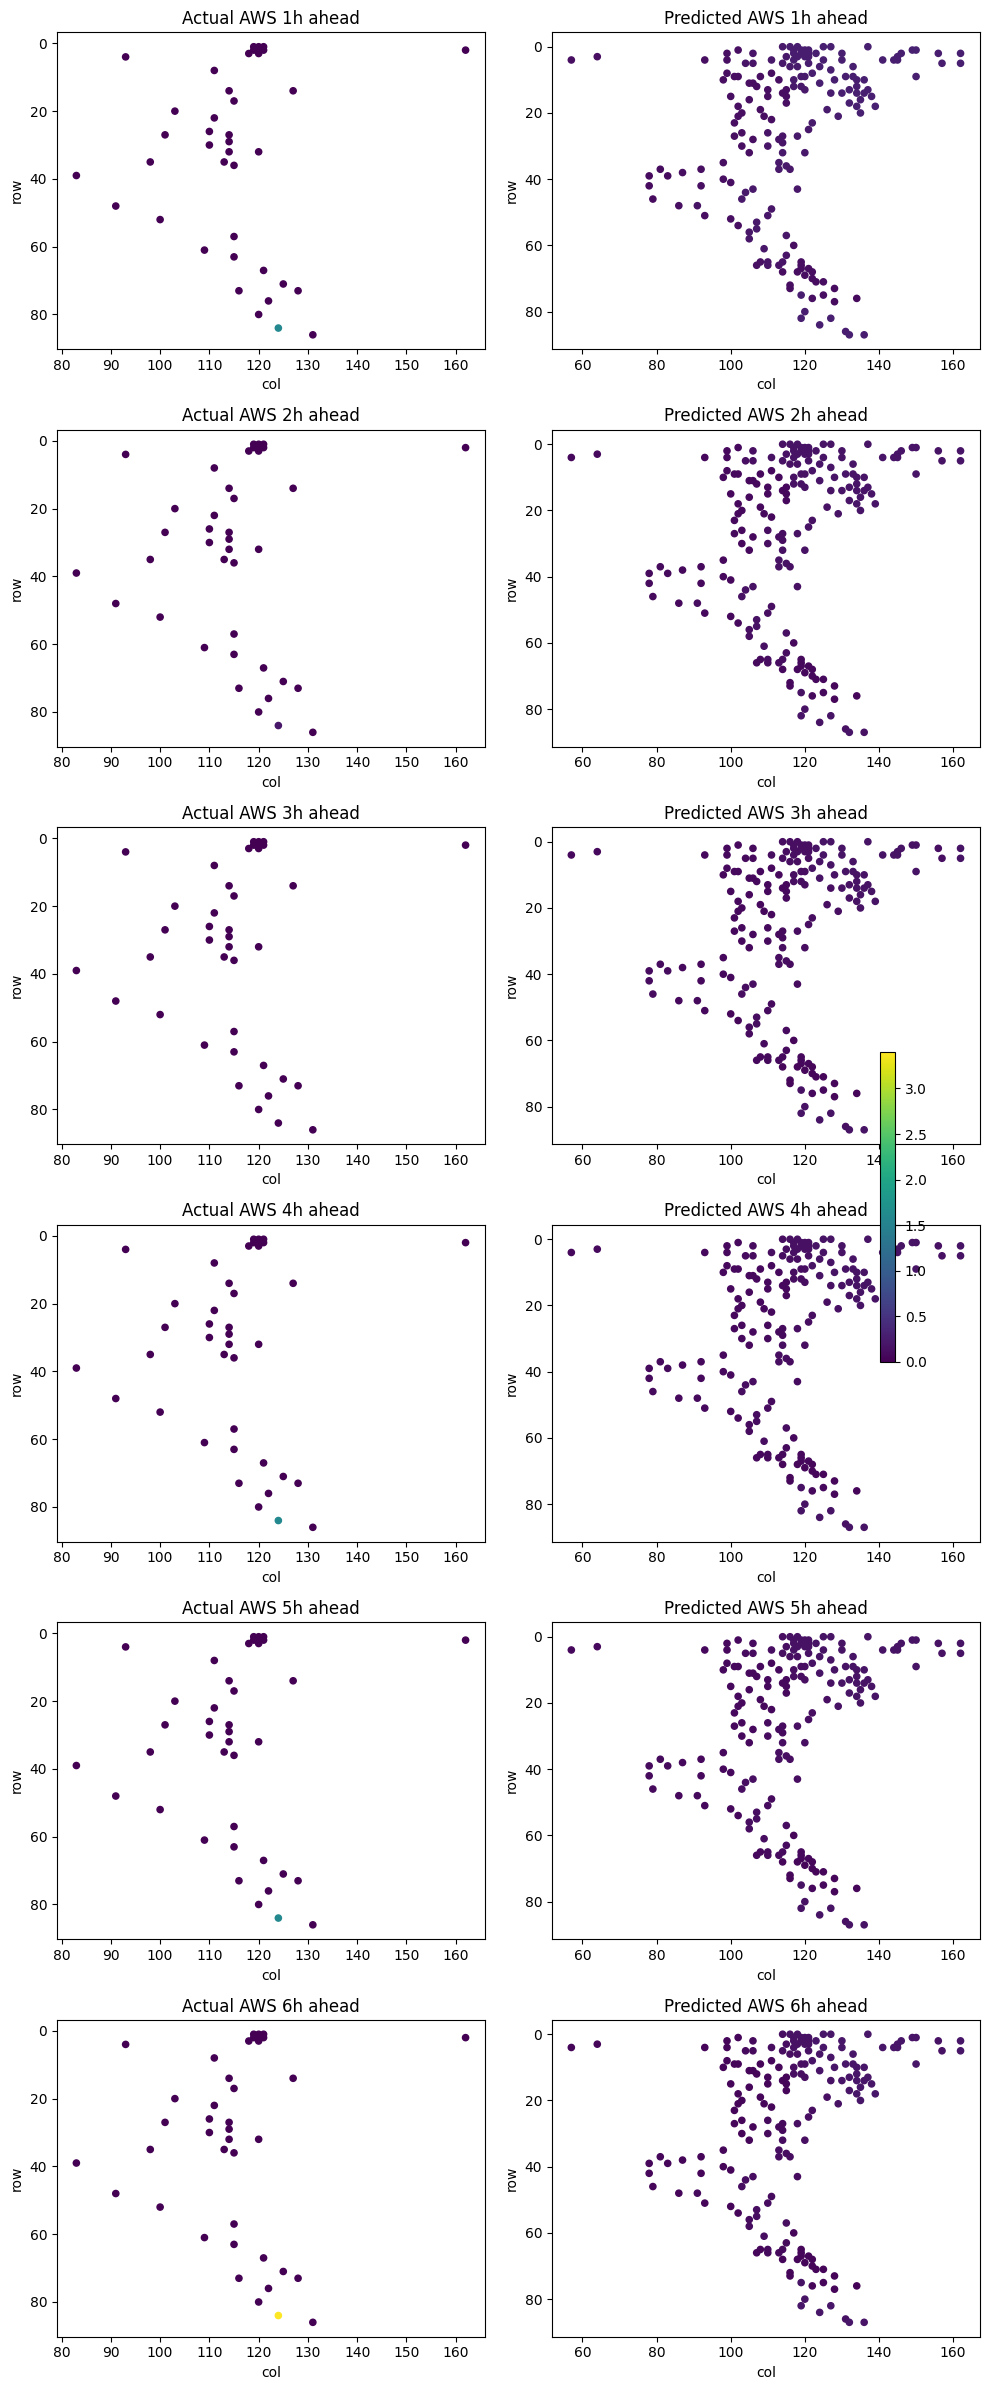

In [7]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-04-15 00:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
